In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.api.types import CategoricalDtype
from tableone import TableOne
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
import shap
from genetic_selection import GeneticSelectionCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
shap.initjs()

/Users/dongyizhi/opt/anaconda3/envs/exposome_conda/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


## XGBoost

### Data Cleaning & Loading

In [2]:
def load_data(df, label, ordinal=True, tableone=False):
    df = df.iloc[:, 4:]
    df.drop(columns='allergy_cum', inplace=True)
    df.dropna(subset=[label+'_label'], inplace=True)

    if tableone:
        columns = list(df.columns)
        categorical = ['ethnicity', 'highest_edu12', 'household_income', 'pc_vig', 'pc_mvpa', 'pg_vig', 
        'pg_mvpa', 'smoking_pg', 'passive_smoke_pc', 'passive_smoke_pg', 'delivery_mode', 'sex', 'infection_m3', 'alcohol_pc', 'alcohol_pg', 
        'antibiotics_labour', 'antibiotics_m3', 'bf_m6', 'maternal_allergy_pw11', 'cat', 'dog', 'expressway', '{}_label'.format(label)]
        groupby = [label+'_label']
        mytable = TableOne(df, columns=columns, categorical=categorical, groupby=groupby, pval=True)
        print(mytable.tabulate(tablefmt="github"))

    # df = df.fillna(df.median())
    # df['pg_mvpa'] = df['pg_mvpa'].fillna(df['pg_mvpa'].median())
    # df['ethnicity'] = df['ethnicity'].astype(int)
    df['ethnicity'] = pd.Categorical(df.ethnicity)

    if ordinal:
        # edu_type = CategoricalDtype(categories=[2, 3, 4, 5, 6], ordered=True)
        inc_type = CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=True)
        vig_type = CategoricalDtype(categories=[0, 1, 2], ordered=True)
        mvpa_type = CategoricalDtype(categories=[0.0, 1.0, 2.0, 3.0], ordered=True)
        # df['highest_edu'] = df['highest_edu'].astype(edu_type)
        df['household_income'] = df['household_income'].astype(inc_type)
        df[['pc_vig', 'pg_vig']] = df[['pc_vig', 'pg_vig']].astype(vig_type)
        df[['pc_mvpa', 'pg_mvpa']] = df[['pc_mvpa', 'pg_mvpa']].astype(mvpa_type)
    
    # print(df.head())
    y = df.loc[:, label+'_label']
    X = df.drop(label+'_label', axis=1)
    # X = df.iloc[:, :-1]
    # y = df.iloc[:, -1]
    return X, y

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [3]:
# to be edited if need different allergy outcomes
outcome = 'wheeze'

gusto = pd.read_csv('data/gusto_{}_edu12.csv'.format(outcome))
gusto.loc[gusto['bf_m6'] == 99, 'bf_m6'] = np.nan
gusto.loc[gusto['ethnicity'] == 4, 'ethnicity'] = np.nan
#gusto.loc[gusto['highest_edu'] == 1, 'highest_edu'] = 2


spresto = pd.read_csv('data/spresto_{}_edu12.csv'.format(outcome))
spresto.loc[spresto['bf_m6'] == 99, 'bf_m6'] = np.nan
spresto.loc[spresto['bisq_q3_m12'] == -8888, 'bisq_q3_m12'] = np.nan
spresto.loc[spresto['bisq_totslphrs_m12'] == -8888, 'bisq_totslphrs_m12'] = np.nan
spresto.loc[spresto['ethnicity'] == 4, 'ethnicity'] = np.nan
#spresto.loc[spresto['highest_edu'] == 1, 'highest_edu'] = 2
spresto['ethnicity'].fillna(99, inplace=True)
spresto['ethnicity'] = spresto['ethnicity'].astype(int)
spresto['ethnicity'] = pd.Categorical(spresto.ethnicity)
spresto.loc[spresto['ethnicity'] == 99, 'ethnicity'] = np.nan
spresto['ethnicity'] = spresto['ethnicity'].cat.remove_unused_categories()

data = pd.concat([gusto, spresto])
data.columns

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Index(['subject_id', 'eczema_cum', 'rhinitis_cum', 'wheeze_cum', 'ethnicity',
       'delivery_age', 'highest_edu12', 'household_income', 'pc_vig',
       'pc_mvpa', 'pg_vig', 'pg_mvpa', 'smoking_pg', 'passive_smoke_pc',
       'passive_smoke_pg', 'delivery_mode', 'sex', 'ga', 'stai_state_pw26',
       'stai_trait_pw26', 'stai_state_m3', 'stai_trait_m3', 'epds_tot_pw26',
       'epds_tot_m3', 'infection_m3', 'alcohol_pc', 'alcohol_pg', 'parity',
       'weight_birth', 'antibiotics_labour', 'antibiotics_m3', 'bisq_q3_m6',
       'bisq_totslphrs_m6', 'bisq_q3_m12', 'bisq_totslphrs_m12', 'bf_m6',
       'maternal_allergy_pw11', 'cat', 'dog', 'expressway', 'allergy_cum',
       'wheeze_label'],
      dtype='object')

In [154]:
print(data['ethnicity'].unique())
print(data['highest_edu12'].unique())
print(data['household_income'].unique())
print(data['pc_vig'].unique())
print(data['pc_mvpa'].unique())
print(data['pg_vig'].unique())
print(data['pg_mvpa'].unique())

[ 1.  2.  3. nan]
[nan  1.  0.]
[nan  2.  3.  5.  4.  1.]
[ 1.  0.  2. nan]
[ 1.  2.  3.  0. nan]
[ 1.  0. nan  2.]
[ 1.  0.  3.  2. nan]


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [155]:
data.head(10)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,subject_id,eczema_cum,rhinitis_cum,wheeze_cum,ethnicity,delivery_age,highest_edu12,household_income,pc_vig,pc_mvpa,pg_vig,pg_mvpa,smoking_pg,passive_smoke_pc,passive_smoke_pg,delivery_mode,sex,ga,stai_state_pw26,stai_trait_pw26,stai_state_m3,stai_trait_m3,epds_tot_pw26,epds_tot_m3,infection_m3,alcohol_pc,alcohol_pg,parity,weight_birth,antibiotics_labour,antibiotics_m3,bisq_q3_m6,bisq_totslphrs_m6,bisq_q3_m12,bisq_totslphrs_m12,bf_m6,maternal_allergy_pw11,cat,dog,expressway,allergy_cum,wheeze_label
0,010-04002,0.0,1.0,1.0,1.0,27.84,NaN,NaN,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,39.57,39.0,68.0,59.0,73.0,21.0,18.0,0.0,0.0,0.0,2.0,3.030,0.0,0.0,10.0,15.000000,NaN,NaN,0.0,NaN,0.0,0.0,0.0,1.0,1.0
1,010-04004,NaN,NaN,NaN,2.0,29.98,1.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,37.29,24.0,39.0,30.0,42.0,13.0,7.0,0.0,0.0,0.0,1.0,2.825,1.0,0.0,9.0,14.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,010-04006,0.0,1.0,0.0,3.0,28.10,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,39.71,39.0,34.0,25.0,30.0,2.0,4.0,0.0,1.0,0.0,1.0,3.925,0.0,1.0,7.0,11.000000,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,NaN
3,010-04010,1.0,NaN,NaN,1.0,32.59,1.0,5.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,37.71,25.0,32.0,NaN,NaN,7.0,NaN,NaN,0.0,0.0,0.0,2.630,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,NaN
4,010-04011,0.0,1.0,0.0,1.0,34.39,0.0,NaN,0.0,3.0,0.0,3.0,0.0,NaN,0.0,2.0,0.0,38.86,23.0,34.0,34.0,29.0,4.0,4.0,0.0,0.0,0.0,2.0,2.860,0.0,0.0,8.5,15.000000,9.5,12.0,0.0,NaN,0.0,1.0,0.0,1.0,NaN
5,010-04012,0.0,1.0,0.0,2.0,29.00,0.0,3.0,0.0,2.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,40.43,25.0,44.0,51.0,57.0,10.0,19.0,0.0,0.0,NaN,1.0,3.690,0.0,1.0,6.0,7.500000,NaN,NaN,0.0,NaN,0.0,0.0,0.0,1.0,NaN
6,010-04020,0.0,0.0,0.0,1.0,39.31,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,39.29,35.0,32.0,21.0,26.0,3.0,6.0,0.0,0.0,0.0,2.0,3.335,0.0,0.0,7.0,15.500000,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,010-04022,1.0,0.0,0.0,3.0,36.52,1.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,38.71,28.0,27.0,44.0,47.0,7.0,14.0,0.0,0.0,0.0,1.0,3.125,0.0,0.0,NaN,NaN,9.5,13.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN
8,010-04023,NaN,1.0,NaN,1.0,34.55,0.0,4.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,38.71,38.0,41.0,33.0,36.0,10.0,8.0,0.0,0.0,NaN,0.0,3.705,0.0,0.0,10.0,11.333333,NaN,NaN,1.0,0.0,0.0,0.0,0.0,1.0,NaN
9,010-04026,0.0,1.0,0.0,2.0,24.02,1.0,3.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,39.00,45.0,43.0,27.0,28.0,1.0,6.0,0.0,0.0,0.0,0.0,3.662,0.0,0.0,6.0,9.500000,NaN,NaN,1.0,0.0,0.0,0.0,0.0,1.0,NaN


In [159]:
pd.set_option('display.max_columns', None)
X, y = load_data(data, label=outcome, ordinal=True, tableone=False)
print(X.shape)
X.head()

(489, 36)


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,ethnicity,delivery_age,highest_edu12,household_income,pc_vig,pc_mvpa,pg_vig,pg_mvpa,smoking_pg,passive_smoke_pc,passive_smoke_pg,delivery_mode,sex,ga,stai_state_pw26,stai_trait_pw26,stai_state_m3,stai_trait_m3,epds_tot_pw26,epds_tot_m3,infection_m3,alcohol_pc,alcohol_pg,parity,weight_birth,antibiotics_labour,antibiotics_m3,bisq_q3_m6,bisq_totslphrs_m6,bisq_q3_m12,bisq_totslphrs_m12,bf_m6,maternal_allergy_pw11,cat,dog,expressway
0,1.0,27.84,NaN,NaN,1,1.0,1,1.0,0.0,1.0,1.0,1.0,0.0,39.57,39.0,68.0,59.0,73.0,21.0,18.0,0.0,0.0,0.0,2.0,3.030,0.0,0.0,10.0,15.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0
6,1.0,39.31,0.0,3,0,0.0,0,0.0,0.0,0.0,0.0,2.0,1.0,39.29,35.0,32.0,21.0,26.0,3.0,6.0,0.0,0.0,0.0,2.0,3.335,0.0,0.0,7.0,15.5,NaN,NaN,0.0,0.0,0.0,0.0,1.0
20,1.0,38.98,1.0,5,2,1.0,0,1.0,0.0,0.0,0.0,2.0,0.0,38.14,33.0,39.0,29.0,34.0,3.0,2.0,0.0,0.0,NaN,2.0,2.950,0.0,0.0,8.0,10.5,NaN,NaN,1.0,0.0,0.0,0.0,0.0
21,2.0,37.83,0.0,2,0,1.0,0,0.0,0.0,1.0,1.0,1.0,0.0,38.86,37.0,42.0,27.0,30.0,8.0,6.0,0.0,0.0,NaN,2.0,3.364,0.0,0.0,6.0,11.0,NaN,NaN,0.0,1.0,0.0,0.0,1.0
23,3.0,28.24,1.0,4,1,1.0,0,0.0,0.0,1.0,1.0,1.0,0.0,38.43,31.0,39.0,35.0,35.0,9.0,6.0,0.0,0.0,0.0,0.0,2.440,0.0,0.0,9.0,14.0,10.0,14.0,0.0,0.0,0.0,0.0,0.0


In [213]:
pd.set_option("display.max_columns", None)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=22)
X_train

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,ethnicity,delivery_age,highest_edu12,household_income,pc_vig,pc_mvpa,pg_vig,pg_mvpa,smoking_pg,passive_smoke_pc,passive_smoke_pg,delivery_mode,sex,ga,stai_state_pw26,stai_trait_pw26,stai_state_m3,stai_trait_m3,epds_tot_pw26,epds_tot_m3,infection_m3,alcohol_pc,alcohol_pg,parity,weight_birth,antibiotics_labour,antibiotics_m3,bisq_q3_m6,bisq_totslphrs_m6,bisq_q3_m12,bisq_totslphrs_m12,bf_m6,maternal_allergy_pw11,cat,dog,expressway
748,1.0,34.32,0.0,NaN,0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,40.14,NaN,NaN,52.0,51.0,7.0,19.0,0.0,0.0,0.0,0.0,3.010,1.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN
299,1.0,29.06,1.0,4,0,3.0,NaN,NaN,0.0,0.0,0.0,1.0,1.0,40.14,23.0,28.0,24.0,26.0,1.0,5.0,0.0,1.0,0.0,0.0,3.185,0.0,0.0,9.0,13.000000,9.0,10.0,1.0,0.0,0.0,0.0,0.0
1066,2.0,31.46,1.0,5,2,1.0,0,0.0,0.0,1.0,0.0,2.0,1.0,40.57,24.0,26.0,23.0,29.0,4.0,4.0,1.0,0.0,0.0,1.0,3.520,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
373,1.0,26.64,1.0,5,1,1.0,NaN,NaN,0.0,0.0,0.0,1.0,0.0,40.86,50.0,40.0,34.0,38.0,12.0,5.0,0.0,1.0,0.0,0.0,3.275,0.0,0.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0
958,1.0,31.90,1.0,5,0,3.0,0,2.0,0.0,0.0,0.0,1.0,0.0,40.14,32.0,35.0,27.0,35.0,6.0,6.0,0.0,1.0,0.0,1.0,2.660,0.0,0.0,10.0,12.000000,9.0,12.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164,2.0,26.36,1.0,3,0,1.0,0,0.0,0.0,1.0,1.0,1.0,0.0,39.71,25.0,28.0,33.0,31.0,1.0,6.0,0.0,0.0,0.0,0.0,3.340,1.0,0.0,10.5,14.500000,12.5,14.0,0.0,1.0,0.0,0.0,0.0
726,1.0,34.55,1.0,4,0,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,39.71,26.0,30.0,20.0,33.0,3.0,4.0,1.0,0.0,0.0,2.0,3.065,0.0,0.0,9.0,14.000000,9.5,13.5,0.0,1.0,0.0,0.0,0.0
615,2.0,26.42,1.0,3,0,0.0,0,0.0,0.0,1.0,1.0,1.0,1.0,35.00,31.0,39.0,22.0,28.0,11.0,2.0,1.0,0.0,0.0,1.0,2.508,0.0,1.0,6.5,7.000000,8.0,9.5,0.0,1.0,0.0,0.0,0.0
1084,1.0,30.21,1.0,4,1,1.0,0,1.0,0.0,0.0,0.0,2.0,0.0,39.57,20.0,26.0,24.0,28.0,4.0,0.0,0.0,0.0,0.0,0.0,3.145,1.0,0.0,10.0,14.000000,11.0,15.0,0.0,1.0,0.0,0.0,0.0


In [204]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 366 entries, 862 to 146
Series name: wheeze_label
Non-Null Count  Dtype  
--------------  -----  
366 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Eczema Parameter

In [43]:
dX= xgb.DMatrix(X, y, enable_categorical=True)
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

param = {"tree_method": "approx", 'max_depth':3, 'min_child_weight': 1, 'objective':'binary:logistic', 'eval_metric': 'auc', 
"eta": 0.01, "subsample": 0.7, 'colsample_bytree': 0.6, 'gamma': 3.3, 'reg_alpha': 1, 'reg_lambda': 3,
    "base_score": np.mean(y_train)}
eval = [(dtrain, "train"), (dtest, "test")]
booster = xgb.train(param, dtrain, 1500, evals=eval, verbose_eval=20, early_stopping_rounds=400)

[0]	train-auc:0.63899	test-auc:0.49849
[20]	train-auc:0.76730	test-auc:0.69861
[40]	train-auc:0.77551	test-auc:0.71235
[60]	train-auc:0.77763	test-auc:0.71103
[80]	train-auc:0.79034	test-auc:0.72816
[100]	train-auc:0.79167	test-auc:0.72703
[120]	train-auc:0.80003	test-auc:0.73513
[140]	train-auc:0.80833	test-auc:0.74078


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[160]	train-auc:0.81211	test-auc:0.74304
[180]	train-auc:0.81530	test-auc:0.74680
[200]	train-auc:0.81743	test-auc:0.75169
[220]	train-auc:0.81937	test-auc:0.75264
[240]	train-auc:0.82311	test-auc:0.75602
[260]	train-auc:0.82480	test-auc:0.75715
[280]	train-auc:0.82655	test-auc:0.75659
[300]	train-auc:0.82784	test-auc:0.75621
[320]	train-auc:0.83067	test-auc:0.75715
[340]	train-auc:0.83330	test-auc:0.75772
[360]	train-auc:0.83605	test-auc:0.75715
[380]	train-auc:0.83839	test-auc:0.75696
[400]	train-auc:0.83987	test-auc:0.75640
[420]	train-auc:0.84103	test-auc:0.75584
[440]	train-auc:0.84226	test-auc:0.75546
[460]	train-auc:0.84477	test-auc:0.75471
[480]	train-auc:0.84781	test-auc:0.75527
[500]	train-auc:0.84969	test-auc:0.75565
[520]	train-auc:0.85273	test-auc:0.75395
[540]	train-auc:0.85345	test-auc:0.75696
[560]	train-auc:0.85509	test-auc:0.75659
[580]	train-auc:0.85579	test-auc:0.75979
[600]	train-auc:0.85649	test-auc:0.75866
[620]	train-auc:0.85712	test-auc:0.75885
[640]	train-auc:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


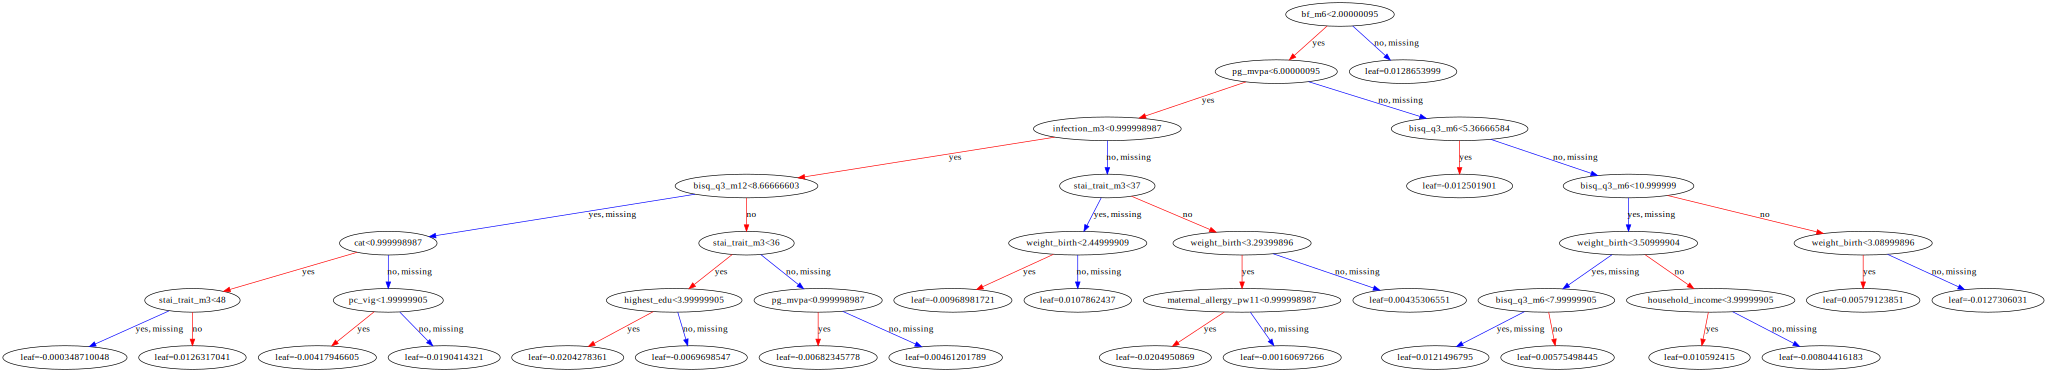

In [101]:
graph = xgb.to_graphviz(booster, num_trees=5)
graph

Rhinitis Parameters

In [78]:
dX= xgb.DMatrix(X, y, enable_categorical=True)
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

param = {"tree_method": "approx", 'max_depth':3, 'min_child_weight': 2, 'objective':'binary:logistic', 'eval_metric': 'auc', 
"eta": 0.01, "subsample": 1, 'colsample_bytree': 0.8, 'gamma': 1.4, 'reg_alpha': 0, 'reg_lambda': 1,
    "base_score": np.mean(y_train)}
eval = [(dtrain, "train"), (dtest, "test")]
booster = xgb.train(param, dtrain, 1500, evals=eval, verbose_eval=20, early_stopping_rounds=250)

[0]	train-auc:0.64577	test-auc:0.55425
[20]	train-auc:0.75648	test-auc:0.61003
[40]	train-auc:0.76446	test-auc:0.62662
[60]	train-auc:0.77291	test-auc:0.62992
[80]	train-auc:0.77628	test-auc:0.62816


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[100]	train-auc:0.78327	test-auc:0.63452
[120]	train-auc:0.79282	test-auc:0.64357
[140]	train-auc:0.79805	test-auc:0.64567
[160]	train-auc:0.80568	test-auc:0.64791
[180]	train-auc:0.80850	test-auc:0.65081
[200]	train-auc:0.81312	test-auc:0.64993
[220]	train-auc:0.81716	test-auc:0.65002
[240]	train-auc:0.82388	test-auc:0.65318
[260]	train-auc:0.83039	test-auc:0.65599
[280]	train-auc:0.83717	test-auc:0.65414
[300]	train-auc:0.84325	test-auc:0.65278
[320]	train-auc:0.85112	test-auc:0.65528
[340]	train-auc:0.85655	test-auc:0.65739
[360]	train-auc:0.86266	test-auc:0.66020
[380]	train-auc:0.86851	test-auc:0.66160
[400]	train-auc:0.87578	test-auc:0.66108
[420]	train-auc:0.88110	test-auc:0.66231
[440]	train-auc:0.88666	test-auc:0.66231
[460]	train-auc:0.89209	test-auc:0.66371
[480]	train-auc:0.89610	test-auc:0.66371
[500]	train-auc:0.90080	test-auc:0.66336
[520]	train-auc:0.90417	test-auc:0.66301
[540]	train-auc:0.90655	test-auc:0.66283
[560]	train-auc:0.90950	test-auc:0.66371
[580]	train-auc:

Wheeze parameter

In [220]:
dX= xgb.DMatrix(X, y, enable_categorical=True)
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

param = {"tree_method": "approx", 'max_depth':5, 'min_child_weight': 9, 'objective':'binary:logistic', 'eval_metric': 'auc', 
"eta": 0.01, "subsample": 0.8, 'colsample_bytree': 0.9, 'gamma': 3.9, 'reg_alpha': 3, 'reg_lambda': 0.1,
    "base_score": np.mean(y_train)}
eval = [(dtrain, "train"), (dtest, "test")]
booster = xgb.train(param, dtrain, 1500, evals=eval, verbose_eval=20, early_stopping_rounds=600)

[0]	train-auc:0.63488	test-auc:0.55879
[20]	train-auc:0.73728	test-auc:0.61507
[40]	train-auc:0.73659	test-auc:0.62553


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[60]	train-auc:0.73595	test-auc:0.62023
[80]	train-auc:0.73942	test-auc:0.62606
[100]	train-auc:0.74540	test-auc:0.62897
[120]	train-auc:0.75019	test-auc:0.63003
[140]	train-auc:0.75303	test-auc:0.63189
[160]	train-auc:0.75590	test-auc:0.62897
[180]	train-auc:0.75928	test-auc:0.63241
[200]	train-auc:0.76413	test-auc:0.63162
[220]	train-auc:0.76548	test-auc:0.63374
[240]	train-auc:0.76691	test-auc:0.63480
[260]	train-auc:0.77149	test-auc:0.63718
[280]	train-auc:0.77206	test-auc:0.63904
[300]	train-auc:0.77236	test-auc:0.63692
[320]	train-auc:0.77316	test-auc:0.63639
[340]	train-auc:0.77382	test-auc:0.63718
[360]	train-auc:0.77601	test-auc:0.63665
[380]	train-auc:0.77810	test-auc:0.63798
[400]	train-auc:0.78004	test-auc:0.63771
[420]	train-auc:0.78022	test-auc:0.63877
[440]	train-auc:0.78136	test-auc:0.63851
[460]	train-auc:0.78178	test-auc:0.63877
[480]	train-auc:0.78226	test-auc:0.63851
[500]	train-auc:0.78392	test-auc:0.63771
[520]	train-auc:0.78609	test-auc:0.63824
[540]	train-auc:0.

In [215]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
cv_auc = xgb.cv(dtrain=dtrain, params=param, folds=cv, shuffle=True, seed=42,
                    num_boost_round=1000, early_stopping_rounds=50, metrics="auc")
cv_auc

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.634916,0.023111,0.532126,0.058057
1,0.679568,0.022369,0.554673,0.071474
2,0.702299,0.015684,0.566214,0.058899
3,0.719838,0.019231,0.564948,0.051179
4,0.726657,0.017838,0.568123,0.055431
...,...,...,...,...
79,0.794134,0.009602,0.585605,0.056997
80,0.794623,0.009570,0.585609,0.058029
81,0.795156,0.009653,0.585856,0.057420
82,0.795595,0.009904,0.585943,0.056518


### XGBoost Tuning

In [216]:
# Tune max_depth & min_child_weight
cv_param = {"tree_method": "approx", 'objective':'binary:logistic', 'eval_metric': 'auc', 
"eta": 0.01, "base_score": np.mean(y_train)}

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3,15)
    for min_child_weight in range(1,10)
]

# Define initial best params and AUC
max_auc = 0
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    cv_param['max_depth'] = max_depth
    cv_param['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        cv_param,
        dtrain,
        num_boost_round=1000,
        seed=42,
        folds=cv,
        metrics={'auc'},
        shuffle=True,
        early_stopping_rounds=80
    )
    # Update best MAE
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (max_depth,min_child_weight)
print("Best params: max_depth = {}, min_child_weight = {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


CV with max_depth=3, min_child_weight=1
	AUC 0.5846140666666667 for 223 rounds
CV with max_depth=3, min_child_weight=2
	AUC 0.5687206 for 174 rounds
CV with max_depth=3, min_child_weight=3
	AUC 0.5756055999999999 for 212 rounds
CV with max_depth=3, min_child_weight=4
	AUC 0.5649624000000001 for 55 rounds
CV with max_depth=3, min_child_weight=5
	AUC 0.5687609333333334 for 120 rounds
CV with max_depth=3, min_child_weight=6
	AUC 0.5732124666666667 for 196 rounds
CV with max_depth=3, min_child_weight=7
	AUC 0.5815796666666667 for 180 rounds
CV with max_depth=3, min_child_weight=8
	AUC 0.5789731333333333 for 255 rounds
CV with max_depth=3, min_child_weight=9
	AUC 0.5855972666666668 for 152 rounds
CV with max_depth=4, min_child_weight=1
	AUC 0.5610668000000001 for 177 rounds
CV with max_depth=4, min_child_weight=2
	AUC 0.5460644 for 32 rounds
CV with max_depth=4, min_child_weight=3
	AUC 0.5638822 for 112 rounds
CV with max_depth=4, min_child_weight=4
	AUC 0.5579820666666666 for 66 rounds
CV 

In [13]:
print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

Best params: 3, 3, AUC: 0.6131250666666668


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [217]:
cv_param = {"tree_method": "approx", 'max_depth': 3, 'min_child_weight': 9, 'objective':'binary:logistic', 
'eval_metric': 'auc', "base_score": np.mean(y_train), 'eta': 0.01}

gridsearch_params = [
    (subsample, colsample_bytree)
    for subsample in [i/10. for i in range(7,11)]
    for colsample_bytree in [i/10. for i in range(6,11)]
]

# Define initial best params and AUC
max_auc = 0
best_params = None
for subsample, colsample_bytree in gridsearch_params:
    print("CV with subsample={}, colsample_bytree={}".format(
                             subsample,
                             colsample_bytree))
    # Update our parameters
    cv_param['subsample'] = subsample
    cv_param['colsample_bytree'] = colsample_bytree
    # Run CV
    cv_results = xgb.cv(
        cv_param,
        dtrain,
        num_boost_round=1000,
        seed=42,
        folds=cv,
        metrics={'auc'},
        shuffle=True,
        early_stopping_rounds=50
    )
    # Update best MAE
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (subsample,colsample_bytree)
print("Best params: subsample = {}, colsample_bytree = {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


CV with subsample=0.7, colsample_bytree=0.6
	AUC 0.587371 for 81 rounds
CV with subsample=0.7, colsample_bytree=0.7
	AUC 0.5853079999999999 for 133 rounds
CV with subsample=0.7, colsample_bytree=0.8
	AUC 0.5856256 for 83 rounds
CV with subsample=0.7, colsample_bytree=0.9
	AUC 0.5844238666666668 for 41 rounds
CV with subsample=0.7, colsample_bytree=1.0
	AUC 0.5875650666666667 for 87 rounds
CV with subsample=0.8, colsample_bytree=0.6
	AUC 0.5888130666666667 for 112 rounds
CV with subsample=0.8, colsample_bytree=0.7
	AUC 0.5915543999999999 for 163 rounds
CV with subsample=0.8, colsample_bytree=0.8
	AUC 0.5899800666666667 for 159 rounds
CV with subsample=0.8, colsample_bytree=0.9
	AUC 0.5930209999999999 for 188 rounds
CV with subsample=0.8, colsample_bytree=1.0
	AUC 0.591696 for 108 rounds
CV with subsample=0.9, colsample_bytree=0.6
	AUC 0.5851269333333333 for 53 rounds
CV with subsample=0.9, colsample_bytree=0.7
	AUC 0.5898182666666666 for 241 rounds
CV with subsample=0.9, colsample_bytre

In [218]:
cv_param = {"tree_method": "approx", 'max_depth': 5, 'min_child_weight': 9, 'objective':'binary:logistic', 'colsample_bytree': 0.9,
'subsample': 0.8, 'eval_metric': 'auc', "base_score": np.mean(y_train), 'eta': 0.01}

gridsearch_params = [
    (gamma)
    for gamma in [i/10. for i in range(0,40)]
]

# Define initial best params and AUC
max_auc = 0
best_params = None
for gamma in gridsearch_params:
    print("CV with gamma={}".format(gamma))
    # Update our parameters
    cv_param['gamma'] = gamma

    # Run CV
    cv_results = xgb.cv(
        cv_param,
        dtrain,
        num_boost_round=500,
        seed=42,
        folds=cv,
        metrics={'auc'},
        shuffle=True,
        early_stopping_rounds=50
    )
    # Update best MAE
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = gamma
print("Best params: gamma = {}, AUC: {}".format(best_params, max_auc))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


CV with gamma=0.0
	AUC 0.5906329333333334 for 166 rounds
CV with gamma=0.1
	AUC 0.5906830000000001 for 166 rounds
CV with gamma=0.2
	AUC 0.5904376666666666 for 179 rounds
CV with gamma=0.3
	AUC 0.5903912666666665 for 177 rounds
CV with gamma=0.4
	AUC 0.5904889333333334 for 177 rounds
CV with gamma=0.5
	AUC 0.5904928666666666 for 177 rounds
CV with gamma=0.6
	AUC 0.5909722666666666 for 178 rounds
CV with gamma=0.7
	AUC 0.5910210666666665 for 178 rounds
CV with gamma=0.8
	AUC 0.5911701333333332 for 178 rounds
CV with gamma=0.9
	AUC 0.5912548666666667 for 215 rounds
CV with gamma=1.0
	AUC 0.5921946000000001 for 217 rounds
CV with gamma=1.1
	AUC 0.5912859333333332 for 176 rounds
CV with gamma=1.2
	AUC 0.5920841333333333 for 166 rounds
CV with gamma=1.3
	AUC 0.5920583333333334 for 216 rounds
CV with gamma=1.4
	AUC 0.5922474 for 215 rounds
CV with gamma=1.5
	AUC 0.5921266000000001 for 189 rounds
CV with gamma=1.6
	AUC 0.5918888000000001 for 218 rounds
CV with gamma=1.7
	AUC 0.5919516 for 216

In [219]:
cv_param = {"tree_method": "approx", 'max_depth': 5, 'min_child_weight': 9, 'colsample_bytree': 0.9, 'objective':'binary:logistic', 
'eval_metric': 'auc',"subsample": 0.8, "base_score": np.mean(y_train), 'eta': 0.01, 'gamma': 3.9}


gridsearch_params = [
    (reg_alpha, reg_lambda)
    for reg_alpha in [0, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]
    for reg_lambda in [0, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]
    # for reg_alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    # for reg_lambda in [1, 2, 3, 4, 5]
]

# Define initial best params and AUC
max_auc = 0
best_params = None
for reg_alpha, reg_lambda in gridsearch_params:
    print("CV with alpha={}, lambda={}".format(
                             reg_alpha,
                             reg_lambda))
    # Update our parameters
    cv_param['reg_alpha'] = reg_alpha
    cv_param['reg_lambda'] = reg_lambda
    # Run CV
    cv_results = xgb.cv(
        cv_param,
        dtrain,
        num_boost_round=800,
        seed=42,
        folds=cv,
        metrics={'auc'},
        early_stopping_rounds=50
    )
    # Update best MAE
    # n = len(cv_results['test-auc-mean'])
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (reg_alpha, reg_lambda)
print("Best params: alpha = {}, lambda = {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


CV with alpha=0, lambda=0
	AUC 0.5955067333333334 for 132 rounds
CV with alpha=0, lambda=0.003
	AUC 0.595607 for 132 rounds
CV with alpha=0, lambda=0.01
	AUC 0.5951495333333333 for 131 rounds
CV with alpha=0, lambda=0.03
	AUC 0.594458 for 146 rounds
CV with alpha=0, lambda=0.1
	AUC 0.5959848666666667 for 213 rounds
CV with alpha=0, lambda=0.3
	AUC 0.5953126 for 160 rounds
CV with alpha=0, lambda=1
	AUC 0.5988239333333334 for 220 rounds
CV with alpha=0, lambda=3
	AUC 0.6035576666666668 for 353 rounds
CV with alpha=0.003, lambda=0
	AUC 0.5954566 for 132 rounds
CV with alpha=0.003, lambda=0.003
	AUC 0.5952548666666666 for 132 rounds
CV with alpha=0.003, lambda=0.01
	AUC 0.5950055333333334 for 136 rounds
CV with alpha=0.003, lambda=0.03
	AUC 0.5952356 for 209 rounds
CV with alpha=0.003, lambda=0.1
	AUC 0.5952521333333334 for 146 rounds
CV with alpha=0.003, lambda=0.3
	AUC 0.5955131333333334 for 160 rounds
CV with alpha=0.003, lambda=1
	AUC 0.5987263333333334 for 220 rounds
CV with alpha=0.

In [221]:
# auc score
train_pred = booster.predict(dtrain)
test_pred = booster.predict(dtest) 

print("Train AUC: %.3f" % roc_auc_score(y_train,train_pred))
print('Test AUC: %.3f' % roc_auc_score(y_test,test_pred))

Train AUC: 0.800
Test AUC: 0.639


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


### Feature Importance & SHAP value

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


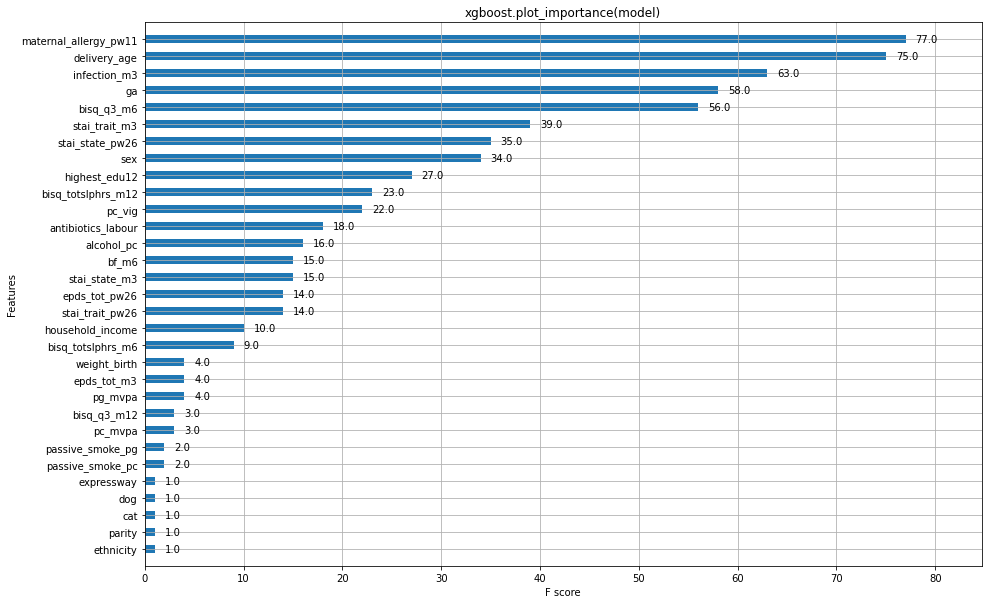

In [222]:
fig, ax = plt.subplots(figsize=(15, 10))
xgb.plot_importance(booster, ax, height=0.5)
plt.title("xgboost.plot_importance(model)")
plt.show()

In [224]:
# booster.get_score()
imp_score = list(booster.get_score().values())

data = list(zip(booster.feature_names, imp_score))
df = pd.DataFrame(data, columns=['feature', 'importance'])
df.sort_values(by='importance', ascending=False).head(15)
# df

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,feature,importance
27,bisq_q3_m6,77.0
1,delivery_age,75.0
17,stai_trait_m3,63.0
10,passive_smoke_pg,58.0
22,alcohol_pg,56.0
14,stai_state_pw26,39.0
11,delivery_mode,35.0
9,passive_smoke_pc,34.0
2,highest_edu12,27.0
25,antibiotics_labour,23.0


In [225]:
# SHAP = booster.predict(dX, pred_interactions=True)

# categorical features are listed as "c"
print(booster.feature_types)
print(booster.feature_names)

['c', 'float', 'float', 'c', 'c', 'c', 'c', 'c', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float']
['ethnicity', 'delivery_age', 'highest_edu12', 'household_income', 'pc_vig', 'pc_mvpa', 'pg_vig', 'pg_mvpa', 'smoking_pg', 'passive_smoke_pc', 'passive_smoke_pg', 'delivery_mode', 'sex', 'ga', 'stai_state_pw26', 'stai_trait_pw26', 'stai_state_m3', 'stai_trait_m3', 'epds_tot_pw26', 'epds_tot_m3', 'infection_m3', 'alcohol_pc', 'alcohol_pg', 'parity', 'weight_birth', 'antibiotics_labour', 'antibiotics_m3', 'bisq_q3_m6', 'bisq_totslphrs_m6', 'bisq_q3_m12', 'bisq_totslphrs_m12', 'bf_m6', 'maternal_allergy_pw11', 'cat', 'dog', 'expressway']


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
# make sure the SHAP values add up to marginal predictions
pred = booster.predict(dX, output_margin=True)
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(dX)
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


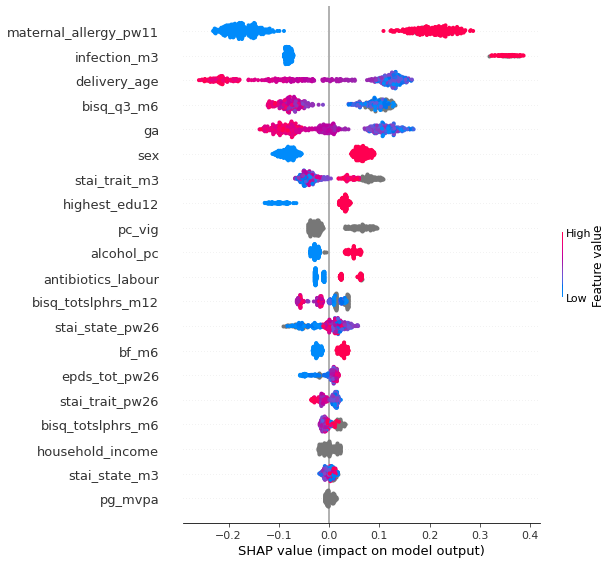

In [227]:
# use the entire dataset
shap.summary_plot(shap_values, X)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


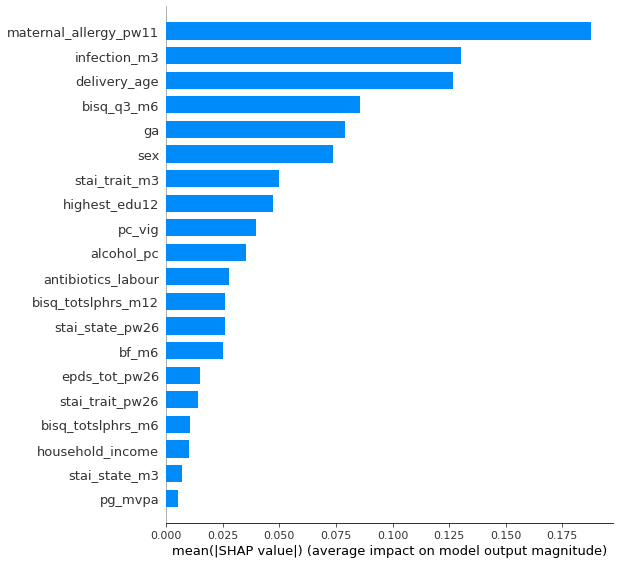

In [228]:
shap.summary_plot(shap_values, X, plot_type="bar")

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


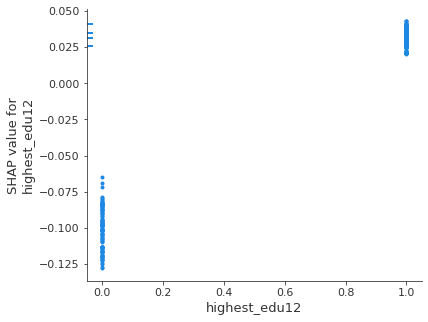

In [229]:
shap.dependence_plot('highest_edu12', shap_values, X, interaction_index=None, show=False)

In [230]:
rf_resultX = pd.DataFrame(shap_values, columns = X_train.columns)

vals = np.abs(rf_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(X_train.columns, vals)),
                                  columns=['col_name','shap_vals'])
shap_importance.sort_values(by=['shap_vals'],
                               ascending=False, inplace=True)
shap_importance.head(15)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,col_name,shap_vals
32,maternal_allergy_pw11,0.187786
20,infection_m3,0.130079
1,delivery_age,0.126473
27,bisq_q3_m6,0.085503
13,ga,0.079042
12,sex,0.073486
17,stai_trait_m3,0.049807
2,highest_edu12,0.047041
4,pc_vig,0.039727
21,alcohol_pc,0.035241


## Genetic algorithm

In [231]:
def load_data(df, label, ordinal=True, tableone=False):
    df = df.iloc[:, 4:]
    df.drop(columns='allergy_cum', inplace=True)
    df.dropna(subset=[label+'_label'], inplace=True)

    if tableone:
        columns = list(df.columns)
        categorical = ['ethnicity', 'highest_edu', 'household_income', 'pc_vig', 'pc_mvpa', 'pg_vig', 
        'pg_mvpa', 'smoking_pg', 'passive_smoke_pc', 'passive_smoke_pg', 'delivery_mode', 'sex', 'infection_m3', 'alcohol_pc', 'alcohol_pg', 
        'antibiotics_labour', 'antibiotics_m3', 'bf_m6', 'maternal_allergy_pw11', 'cat', 'dog', 'expressway', '{}_label'.format(label)]
        groupby = [label+'_label']
        mytable = TableOne(df, columns=columns, categorical=categorical, groupby=groupby, pval=True)
        print(mytable.tabulate(tablefmt="github"))

    df = df.fillna(df.median())
    df['ethnicity'] = pd.Categorical(df.ethnicity)    
    # d = pd.get_dummies(df['ethnicity'], prefix='echnicity')
    # df = pd.concat([df, d], axis=1)
    # df = df.drop('ethnicity', axis=1)
    df[label+'_label'] = df[label+'_label'].astype(int)


    if ordinal:
        # edu_type = CategoricalDtype(categories=[2, 3, 4, 5, 6], ordered=True)
        inc_type = CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=True)
        vig_type = CategoricalDtype(categories=[0, 1, 2], ordered=True)
        mvpa_type = CategoricalDtype(categories=[0.0, 1.0, 2.0, 3.0], ordered=True)
        # df['highest_edu'] = df['highest_edu'].astype(edu_type)
        df['household_income'] = df['household_income'].astype(inc_type)
        df[['pc_vig', 'pg_vig']] = df[['pc_vig', 'pg_vig']].astype(vig_type)
        df[['pc_mvpa', 'pg_mvpa']] = df[['pc_mvpa', 'pg_mvpa']].astype(mvpa_type)
    
    # print(df.head())
    y = df.loc[:, label+'_label']
    X = df.drop(label+'_label', axis=1)
    return X, y

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [232]:
# to be edited if need different allergy outcomes
outcome = 'wheeze'

gusto = pd.read_csv('data/gusto_{}_edu12.csv'.format(outcome))
gusto.loc[gusto['bf_m6'] == 99, 'bf_m6'] = np.nan
gusto.loc[gusto['ethnicity'] == 4, 'ethnicity'] = np.nan
# gusto.loc[gusto['highest_edu'] == 1, 'highest_edu'] = 2

spresto = pd.read_csv('data/spresto_{}_edu12.csv'.format(outcome))
spresto.loc[spresto['bf_m6'] == 99, 'bf_m6'] = np.nan
spresto.loc[spresto['bisq_q3_m12'] == -8888, 'bisq_q3_m12'] = np.nan
spresto.loc[spresto['bisq_totslphrs_m12'] == -8888, 'bisq_totslphrs_m12'] = np.nan
spresto.loc[spresto['ethnicity'] == 4, 'ethnicity'] = np.nan
# spresto.loc[spresto['highest_edu'] == 1, 'highest_edu'] = 2
spresto['ethnicity'].fillna(99, inplace=True)
spresto['ethnicity'] = spresto['ethnicity'].astype(int)
spresto['ethnicity'] = pd.Categorical(spresto.ethnicity)
spresto.loc[spresto['ethnicity'] == 99, 'ethnicity'] = np.nan
spresto['ethnicity'] = spresto['ethnicity'].cat.remove_unused_categories()

data = pd.concat([gusto, spresto])
data['delivery_mode'] = data['delivery_mode']-1
data.shape

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


(1616, 42)

In [233]:
X, y = load_data(data, label=outcome, ordinal=False, tableone=False)
print(X.shape)
X.head()

(489, 36)


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,ethnicity,delivery_age,highest_edu12,household_income,pc_vig,pc_mvpa,pg_vig,pg_mvpa,smoking_pg,passive_smoke_pc,passive_smoke_pg,delivery_mode,sex,ga,stai_state_pw26,stai_trait_pw26,stai_state_m3,stai_trait_m3,epds_tot_pw26,epds_tot_m3,infection_m3,alcohol_pc,alcohol_pg,parity,weight_birth,antibiotics_labour,antibiotics_m3,bisq_q3_m6,bisq_totslphrs_m6,bisq_q3_m12,bisq_totslphrs_m12,bf_m6,maternal_allergy_pw11,cat,dog,expressway
0,1.0,27.84,1.0,4.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,39.57,39.0,68.0,59.0,73.0,21.0,18.0,0.0,0.0,0.0,2.0,3.030,0.0,0.0,10.0,15.0,9.5,12.0,0.0,0.0,0.0,0.0,0.0
6,1.0,39.31,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,39.29,35.0,32.0,21.0,26.0,3.0,6.0,0.0,0.0,0.0,2.0,3.335,0.0,0.0,7.0,15.5,9.5,12.0,0.0,0.0,0.0,0.0,1.0
20,1.0,38.98,1.0,5.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,38.14,33.0,39.0,29.0,34.0,3.0,2.0,0.0,0.0,0.0,2.0,2.950,0.0,0.0,8.0,10.5,9.5,12.0,1.0,0.0,0.0,0.0,0.0
21,2.0,37.83,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,38.86,37.0,42.0,27.0,30.0,8.0,6.0,0.0,0.0,0.0,2.0,3.364,0.0,0.0,6.0,11.0,9.5,12.0,0.0,1.0,0.0,0.0,1.0
23,3.0,28.24,1.0,4.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,38.43,31.0,39.0,35.0,35.0,9.0,6.0,0.0,0.0,0.0,0.0,2.440,0.0,0.0,9.0,14.0,10.0,14.0,0.0,0.0,0.0,0.0,0.0


In [234]:
X['highest_edu12'].unique()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


array([1., 0.])

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


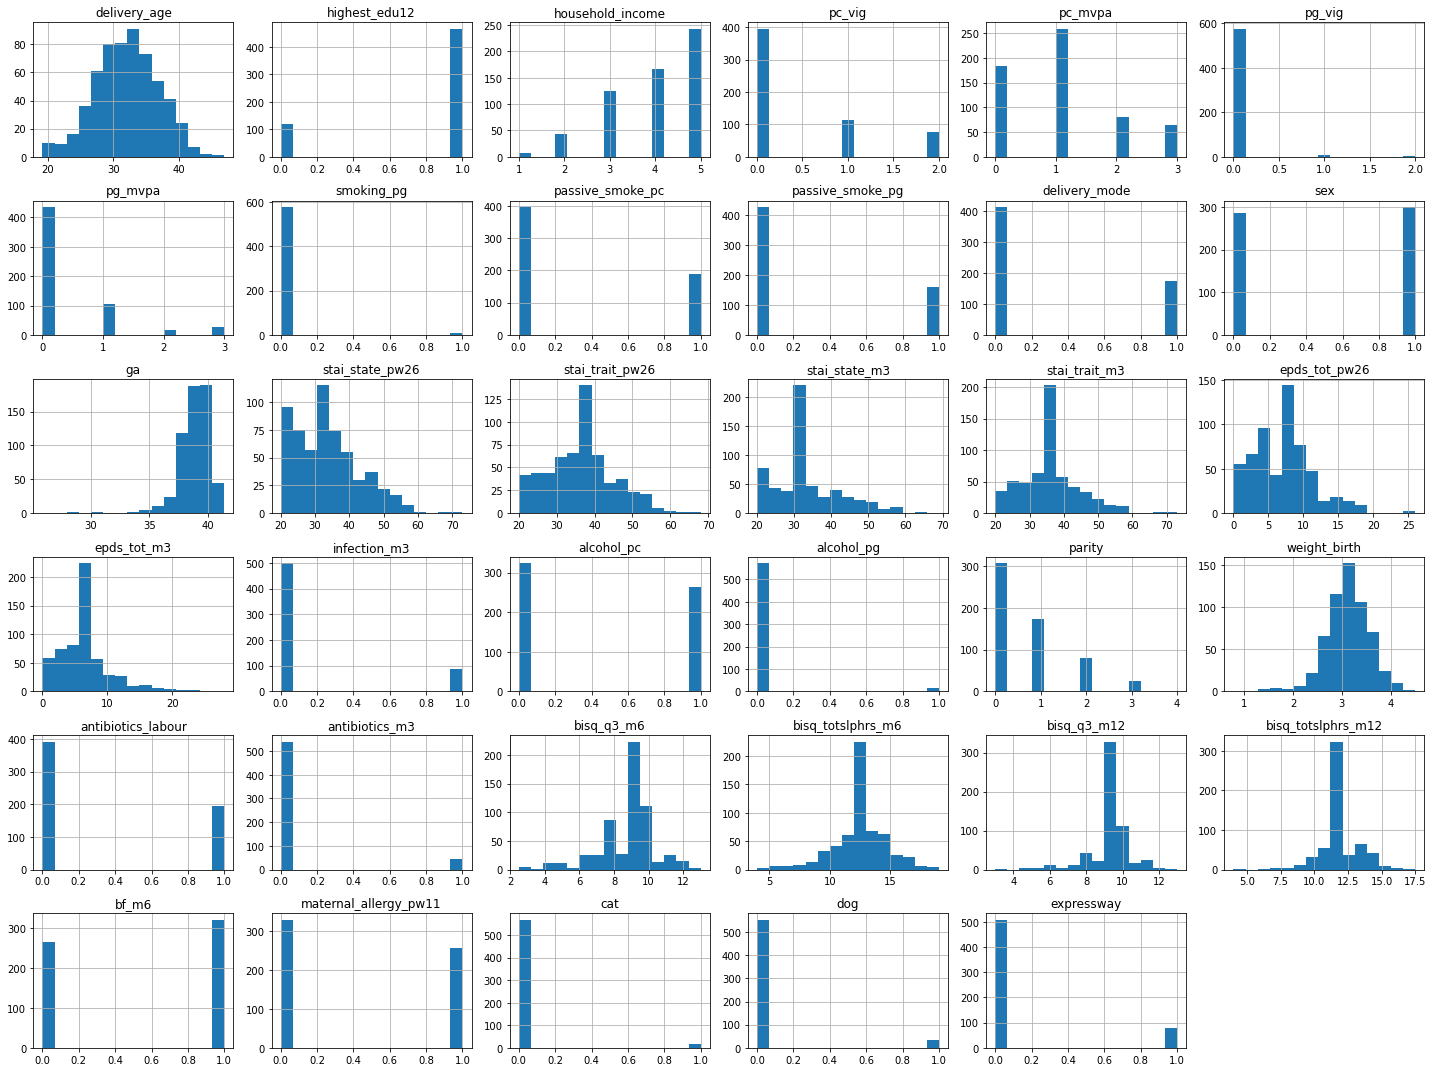

In [93]:
X.hist(bins=15, figsize=(20, 15))
plt.tight_layout()
plt.show()

In [92]:
X.columns

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Index(['ethnicity', 'delivery_age', 'highest_edu12', 'household_income',
       'pc_vig', 'pc_mvpa', 'pg_vig', 'pg_mvpa', 'smoking_pg',
       'passive_smoke_pc', 'passive_smoke_pg', 'delivery_mode', 'sex', 'ga',
       'stai_state_pw26', 'stai_trait_pw26', 'stai_state_m3', 'stai_trait_m3',
       'epds_tot_pw26', 'epds_tot_m3', 'infection_m3', 'alcohol_pc',
       'alcohol_pg', 'parity', 'weight_birth', 'antibiotics_labour',
       'antibiotics_m3', 'bisq_q3_m6', 'bisq_totslphrs_m6', 'bisq_q3_m12',
       'bisq_totslphrs_m12', 'bf_m6', 'maternal_allergy_pw11', 'cat', 'dog',
       'expressway'],
      dtype='object')

In [235]:
r_data = pd.concat([X, y], axis=1)
r_data.head()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,ethnicity,delivery_age,highest_edu12,household_income,pc_vig,pc_mvpa,pg_vig,pg_mvpa,smoking_pg,passive_smoke_pc,passive_smoke_pg,delivery_mode,sex,ga,stai_state_pw26,stai_trait_pw26,stai_state_m3,stai_trait_m3,epds_tot_pw26,epds_tot_m3,infection_m3,alcohol_pc,alcohol_pg,parity,weight_birth,antibiotics_labour,antibiotics_m3,bisq_q3_m6,bisq_totslphrs_m6,bisq_q3_m12,bisq_totslphrs_m12,bf_m6,maternal_allergy_pw11,cat,dog,expressway,wheeze_label
0,1.0,27.84,1.0,4.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,39.57,39.0,68.0,59.0,73.0,21.0,18.0,0.0,0.0,0.0,2.0,3.030,0.0,0.0,10.0,15.0,9.5,12.0,0.0,0.0,0.0,0.0,0.0,1
6,1.0,39.31,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,39.29,35.0,32.0,21.0,26.0,3.0,6.0,0.0,0.0,0.0,2.0,3.335,0.0,0.0,7.0,15.5,9.5,12.0,0.0,0.0,0.0,0.0,1.0,0
20,1.0,38.98,1.0,5.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,38.14,33.0,39.0,29.0,34.0,3.0,2.0,0.0,0.0,0.0,2.0,2.950,0.0,0.0,8.0,10.5,9.5,12.0,1.0,0.0,0.0,0.0,0.0,0
21,2.0,37.83,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,38.86,37.0,42.0,27.0,30.0,8.0,6.0,0.0,0.0,0.0,2.0,3.364,0.0,0.0,6.0,11.0,9.5,12.0,0.0,1.0,0.0,0.0,1.0,1
23,3.0,28.24,1.0,4.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,38.43,31.0,39.0,35.0,35.0,9.0,6.0,0.0,0.0,0.0,0.0,2.440,0.0,0.0,9.0,14.0,10.0,14.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
# one-hot encoding
cat_col = ['ethnicity', 'household_income', 'pc_vig', 'pc_mvpa', 'pg_vig', 'pg_mvpa']
X = pd.get_dummies(X, columns = cat_col, drop_first=False)
X.head()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,delivery_age,highest_edu12,smoking_pg,passive_smoke_pc,passive_smoke_pg,delivery_mode,sex,ga,stai_state_pw26,stai_trait_pw26,stai_state_m3,stai_trait_m3,epds_tot_pw26,epds_tot_m3,infection_m3,alcohol_pc,alcohol_pg,parity,weight_birth,antibiotics_labour,antibiotics_m3,bisq_q3_m6,bisq_totslphrs_m6,bisq_q3_m12,bisq_totslphrs_m12,bf_m6,maternal_allergy_pw11,cat,dog,expressway,ethnicity_1.0,ethnicity_2.0,ethnicity_3.0,household_income_1.0,household_income_2.0,household_income_3.0,household_income_4.0,household_income_5.0,pc_vig_0.0,pc_vig_1.0,pc_vig_2.0,pc_mvpa_0.0,pc_mvpa_1.0,pc_mvpa_2.0,pc_mvpa_3.0,pg_vig_0.0,pg_vig_1.0,pg_vig_2.0,pg_mvpa_0.0,pg_mvpa_1.0,pg_mvpa_2.0,pg_mvpa_3.0
0,27.84,1.0,0.0,1.0,1.0,0.0,0.0,39.57,39.0,68.0,59.0,73.0,21.0,18.0,0.0,0.0,0.0,2.0,3.030,0.0,0.0,10.0,15.0,9.5,12.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0
6,39.31,0.0,0.0,0.0,0.0,1.0,1.0,39.29,35.0,32.0,21.0,26.0,3.0,6.0,0.0,0.0,0.0,2.0,3.335,0.0,0.0,7.0,15.5,9.5,12.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0
20,38.98,1.0,0.0,0.0,0.0,1.0,0.0,38.14,33.0,39.0,29.0,34.0,3.0,2.0,0.0,0.0,0.0,2.0,2.950,0.0,0.0,8.0,10.5,9.5,12.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0
21,37.83,0.0,0.0,1.0,1.0,0.0,0.0,38.86,37.0,42.0,27.0,30.0,8.0,6.0,0.0,0.0,0.0,2.0,3.364,0.0,0.0,6.0,11.0,9.5,12.0,0.0,1.0,0.0,0.0,1.0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0
23,28.24,1.0,0.0,1.0,1.0,0.0,0.0,38.43,31.0,39.0,35.0,35.0,9.0,6.0,0.0,0.0,0.0,0.0,2.440,0.0,0.0,9.0,14.0,10.0,14.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0


In [272]:
pd.set_option('display.max_columns', None)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=33)
X_train.describe()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,delivery_age,highest_edu12,smoking_pg,passive_smoke_pc,passive_smoke_pg,delivery_mode,sex,ga,stai_state_pw26,stai_trait_pw26,stai_state_m3,stai_trait_m3,epds_tot_pw26,epds_tot_m3,infection_m3,alcohol_pc,alcohol_pg,parity,weight_birth,antibiotics_labour,antibiotics_m3,bisq_q3_m6,bisq_totslphrs_m6,bisq_q3_m12,bisq_totslphrs_m12,bf_m6,maternal_allergy_pw11,cat,dog,expressway,ethnicity_1.0,ethnicity_2.0,ethnicity_3.0,household_income_1.0,household_income_2.0,household_income_3.0,household_income_4.0,household_income_5.0,pc_vig_0.0,pc_vig_1.0,pc_vig_2.0,pc_mvpa_0.0,pc_mvpa_1.0,pc_mvpa_2.0,pc_mvpa_3.0,pg_vig_0.0,pg_vig_1.0,pg_vig_2.0,pg_mvpa_0.0,pg_mvpa_1.0,pg_mvpa_2.0,pg_mvpa_3.0
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,31.694071,0.756831,0.016393,0.368852,0.327869,0.316940,0.543716,38.798169,33.890710,36.133880,33.254098,35.997268,7.049180,5.969945,0.133880,0.377049,0.027322,0.844262,3.112164,0.308743,0.060109,8.677140,12.092441,9.306466,11.999089,0.467213,0.420765,0.030055,0.060109,0.114754,0.628415,0.245902,0.125683,0.016393,0.084699,0.265027,0.297814,0.336066,0.683060,0.177596,0.139344,0.330601,0.401639,0.131148,0.136612,0.972678,0.019126,0.008197,0.721311,0.191257,0.030055,0.057377
std,4.889075,0.429584,0.127157,0.483154,0.470079,0.465921,0.498767,1.478771,9.851727,9.082942,8.694412,8.719840,4.530298,4.305037,0.340989,0.485311,0.163244,0.970980,0.429092,0.462607,0.238015,1.686617,2.334261,1.159354,1.472528,0.499607,0.494358,0.170971,0.238015,0.319161,0.483890,0.431210,0.331946,0.127157,0.278815,0.441952,0.457923,0.473008,0.465921,0.382695,0.346779,0.471074,0.490901,0.338024,0.343907,0.163244,0.137154,0.090287,0.448968,0.393829,0.170971,0.232880
min,19.590000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.860000,20.000000,20.000000,20.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.780000,0.000000,0.000000,2.500000,4.000000,4.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.415000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.140000,26.000000,29.000000,28.000000,31.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.854250,0.000000,0.000000,8.000000,11.000000,9.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,31.760000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,39.000000,34.000000,36.000000,32.000000,35.000000,7.000000,5.000000,0.000000,0.000000,0.000000,1.000000,3.115500,0.000000,0.000000,9.000000,12.000000,9.500000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,35.175000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,39.710000,38.750000,41.000000,37.000000,40.000000,10.000000,8.000000,0.000000,1.000000,0.000000,1.000000,3.369500,1.000000,0.000000,9.500000,13.500000,10.000000,12.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000

In [ ]:
# data normalization
sd = StandardScaler()
X_train_sc = sd.fit_transform(X_train)
X_test_sc = sd.transform(X_test)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [275]:
pd.DataFrame(X_train_sc, columns=X.columns).describe()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,delivery_age,highest_edu12,smoking_pg,passive_smoke_pc,passive_smoke_pg,delivery_mode,sex,ga,stai_state_pw26,stai_trait_pw26,stai_state_m3,stai_trait_m3,epds_tot_pw26,epds_tot_m3,infection_m3,alcohol_pc,alcohol_pg,parity,weight_birth,antibiotics_labour,antibiotics_m3,bisq_q3_m6,bisq_totslphrs_m6,bisq_q3_m12,bisq_totslphrs_m12,bf_m6,maternal_allergy_pw11,cat,dog,expressway,ethnicity_1.0,ethnicity_2.0,ethnicity_3.0,household_income_1.0,household_income_2.0,household_income_3.0,household_income_4.0,household_income_5.0,pc_vig_0.0,pc_vig_1.0,pc_vig_2.0,pc_mvpa_0.0,pc_mvpa_1.0,pc_mvpa_2.0,pc_mvpa_3.0,pg_vig_0.0,pg_vig_1.0,pg_vig_2.0,pg_mvpa_0.0,pg_mvpa_1.0,pg_mvpa_2.0,pg_mvpa_3.0
count,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02,3.660000e+02
mean,-6.740206e-16,7.765494e-17,2.184045e-17,-1.601633e-16,1.164824e-16,-1.067755e-16,-6.794808e-17,-1.566446e-15,8.978853e-17,-1.674435e-16,-1.577366e-16,3.737144e-16,-7.522823e-17,1.213358e-18,1.213358e-17,-3.397404e-17,-4.125419e-17,-6.066792e-17,1.032568e-15,-6.309464e-17,1.067755e-16,-3.543007e-16,8.202303e-16,-3.530873e-16,-1.977774e-16,-2.426717e-17,-5.824121e-17,3.882747e-17,8.432842e-17,-4.853434e-18,-1.274026e-16,2.912060e-17,4.853434e-18,1.213358e-17,3.397404e-17,1.213358e-17,3.154732e-17,2.912060e-17,8.736181e-17,-9.706868e-18,-4.125419e-17,-5.824121e-17,-9.706868e-18,9.706868e-18,-1.116290e-16,1.310427e-16,2.912060e-17,-6.794808e-17,-1.456030e-17,5.338777e-17,6.552136e-17,-9.706868e-18
std,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00,1.001369e+00
min,-2.479127e+00,-1.764188e+00,-1.290994e-01,-7.644708e-01,-6.984303e-01,-6.811755e-01,-1.091612e+00,-8.761247e+00,-1.411907e+00,-1.778715e+00,-1.526526e+00,-1.837094e+00,-1.558138e+00,-1.388633e+00,-3.931592e-01,-7.779866e-01,-1.676004e-01,-8.706851e-01,-5.442553e+00,-6.683115e-01,-2.528903e-01,-3.667458e+00,-3.471556e+00,-4.583356e+00,-4.759616e+00,-9.364417e-01,-8.522999e-01,-1.760282e-01,-2.528903e-01,-3.600411e-01,-1.300452e+00,-5.710402e-01,-3.791438e-01,-1.290994e-01,-3.041995e-01,-6.004955e-01,-6.512484e-01,-7.114582e-01,-1.468051e+00,-4.647008e-01,-4.023739e-01,-7.027642e-01,-8.192880e-01,-3.885143e-01,-3.977786e-01,-5.966574e+00,-1.396374e-01,-9.090909e-02,-1.608799e+00,-4.862988e-01,-1.760282e-01,-2.467176e-01
25%,-6.716116e-01,5.668330e-01,-1.290994e-01,-7.644708e-01,-6.984303e-01,-6.811755e-01,-1.091612e+00,-4.456878e-01,-8.020434e-01,-7.864903e-01,-6.051348e-01,-5.738762e-01,-6.739853e-01,-6.908213e-01,-3.931592e-01,-7.779866e-01,-1.676004e-01,-8.706851e-01,-6.018918e-01,-6.683115e-01,-2.528903e-01,-4.020280e-01,-4.686435e-01,-2.647042e-01,6.193385e-04,-9.364417e-01,-8.522999e-01,-1.760282e-01,-2.528903e-01,-3.600411e-01,-1.300452e+00,-5.710402e-01,-3.791438e-01,-1.290994e-01,-3.041995e-01,-6.004955e-01,-6.5124

In [ ]:
estimator = LogisticRegression(max_iter=1e5)

selector = GeneticSelectionCV(
    estimator,
    cv=5,
    verbose=1,
    scoring="roc_auc",
    max_features=None,
    n_population=80,
    crossover_proba=0.5,
    mutation_proba=0.2,
    n_generations=100,
    crossover_independent_proba=0.5,
    mutation_independent_proba=0.04,
    tournament_size=3,
    n_gen_no_change=20,
    caching=True,
    n_jobs=-1,
)
selector = selector.fit(X_train_sc, y_train)

In [293]:
print(selector.support_)
print(selector.n_features_)
print(selector.generation_scores_)

[False  True  True False  True False False  True  True  True False  True
  True  True  True False False False False False False False  True False
 False  True  True False False  True False  True False  True  True  True
 False False False False False False False  True  True False  True False
 False False False False]
21
[0.62134567 0.62546751 0.63401581 0.63401581 0.63806825 0.63806825
 0.64304222 0.64336996 0.64342009 0.65044149 0.65044149 0.65044149
 0.65044149 0.65044149 0.65420089 0.65420089 0.65420089 0.65587816
 0.65587816 0.65587816 0.65688066 0.65688066 0.65787546 0.65787546
 0.65787546 0.65787546 0.65787546 0.65787546 0.65787546 0.65787546
 0.65787546 0.65787546 0.65787546 0.65787546 0.65787546 0.65787546
 0.65787546 0.65787546 0.65787546 0.65787546 0.65787546 0.65787546
 0.65787546]


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [294]:
print('train AUC:', selector.score(X_train_sc, y_train))
print('test AUC:', selector.score(X_test_sc, y_test))

train AUC: 0.6693989071038251
test AUC: 0.6178861788617886


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [295]:
# selected features by the model
pd.DataFrame(X.columns[selector.support_])

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,0
0,highest_edu12
1,smoking_pg
2,passive_smoke_pg
3,ga
4,stai_state_pw26
5,stai_trait_pw26
6,stai_trait_m3
7,epds_tot_pw26
8,epds_tot_m3
9,infection_m3


## Logistic Regression

In [ ]:
pd.set_option('display.max_columns', None)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=64)
X_train.describe()

In [ ]:
sd = StandardScaler()
X_train_sc = sd.fit_transform(X_train)
X_test_sc = sd.transform(X_test)
X_sc = sd.transform(X)

In [ ]:
model = sm.GLM(np.array(y_train), sm.add_constant(pd.DataFrame(X_train_sc, columns=X_train.columns)))
results = model.fit()
print(results.summary())

In [ ]:
# dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)
train_pred = results.predict(sm.add_constant(pd.DataFrame(X_train_sc, columns=X_train.columns), has_constant='add'))
test_pred = results.predict(sm.add_constant(pd.DataFrame(X_test_sc, columns=X_train.columns), has_constant='add'))

print("train AUC: %.3f" % roc_auc_score(y_train,train_pred))
print("test AUC: %.3f" % roc_auc_score(y_test,test_pred))

In [ ]:
def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    OR = np.exp(coeff)
    coef_lower = results.conf_int()[0]
    coef_upper = results.conf_int()[1]
    or_lower = np.exp(results.conf_int()[0])
    or_upper = np.exp(results.conf_int()[1])

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff,
                                "Odds ratio": OR,
                                "coef lower": coef_lower,
                                "coef upper": coef_upper,
                               "or lower":or_lower,
                               "or upper":or_upper
                                })

    #Reordering...
    results_df = results_df[["coeff", "Odds ratio", "pvals","coef lower","coef upper", "or lower", "or upper"]]
    return results_df.round(3)

In [ ]:
table = results_summary_to_dataframe(results)
table = table.reset_index()
table.sort_values(by='pvals', ascending=True).loc[:, ['index', 'coeff', 'pvals']].head(15)

In [ ]:
table.loc[18, 'pvals'] <= 0.05